<a href="https://colab.research.google.com/github/Shimon-ar/seam-carving/blob/main/seam_carving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import time

from PIL import Image
import io as io
from skimage import io as skimage_io 
import urllib

!pip install anvil-uplink
import anvil.media
import anvil.server
anvil.server.connect("YA6JKGHCNQ5PLAOLCLZOPJS5-4IUH7CMMIZ3AABLA")


     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 61kB 5.7MB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-cp37-none-any.whl size=45216 sha256=8520f696e07cef1922607c02f9318e7f722012116fcd3ddbea7c0073ddcac8cb
  Stored in directory: /root/.cache/pip/wheels/a2/6e/4e/8b0ae12fb9b8a05715256952cf7609a8ab86285fab99b88c68
Successfully built ws4py


Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment (dev)" as SERVER


In [28]:
# Constants 

ROW = 640
WIDTH = 420
SCALE = 0.8
NEG_VALUE = -1000
num_img = 6
images = []
i_img = -1

path = '/content/drive/MyDrive/images/'
img_names = ['pelicans.jpg', 'buildings.jpg', 'couple.jpg', 'couple2.jpg', 'road.jpg', 'beach.jpg']

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# Gets img as numpy array 
# Return energy map E1
 
def get_energy_map(img):
  img_grey = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
  img_d_x = np.absolute(cv.Sobel(img_grey,cv.CV_64F,1,0,ksize=1))
  img_d_y = np.absolute(cv.Sobel(img_grey,cv.CV_64F,0,1,ksize=1))
  return np.uint8(img_d_x + img_d_y)

In [6]:
# Gets img, and energy map
# Calculate M matrix
# return optimal seam in the image as array of column indexs

def get_min_seam(img, e):
  r, c, _ = img.shape

  M = np.zeros((r,c), dtype=np.int32)
  backtrack = M.copy().astype(np.int)
  M[0] = e[0]
  
  strides = M[0].strides+(M[0].strides[-1],)
  idx_offset = np.pad(np.arange(c-1), (1,0), 'edge') 

  for i in range(1,r):
    w_arr = np.lib.stride_tricks.as_strided(np.pad(M[i-1],(1,1),'edge') , shape=(c,3), strides=strides)
    min_idx =  np.argmin(w_arr, axis=1) + idx_offset
    M[i] = e[i] + M[i-1][min_idx]
    backtrack[i] = min_idx 
    
  min_seam = np.zeros(r, dtype=np.int)
  j = np.argmin(M[-1])
  
  for i in range(r-1,-1,-1):
    min_seam[i] = j
    j = backtrack[i,j]

  return min_seam




In [7]:
# gets matrix, and 4 coordinates x1 < x2 , y1 < y2 for square
# create mask for m with ones all over the square

def create_square_mask(m, x1, x2, y1, y2):
  r,c = m.shape[:2]
  mask = np.zeros(r*c, np.bool)
  X = np.arange(x1, x2+1)
  idx = np.stack([X]*(y2-y1+1), axis=1) + np.arange(y1,y2+1)*c
  mask[idx.flatten()] = 1
  return mask.reshape((r,c))


# gets m = matrix which each column fill with column indexes to put ones in the mask over a row
# r = num rows of mask
# c = num columns of mask
# d = depth of the mask , None for 2D 
# return the desired mask

def create_mask(m, r, c, d=None):
  _ , c_m = m.shape
  mask = np.zeros(r*c, dtype=np.bool)
  offsets = np.arange(0,r*c,c)
  offsets = np.repeat(offsets, c_m)
  mask[offsets+m.flatten()] = 1
  mask = mask.reshape((r,c))
  
  if not d:
    return mask
  
  return np.stack([mask]*d, axis=2)


In [9]:
# Gets m = matrix, 
# seam = array of column indexes
# d = depth of m , None for 2D
# return m without the seam

def remove_seam(m, seam, d = None):
  r,c = m.shape[:2]
  mask = ~create_mask(seam.reshape((r,1)),r,c,d)
  if not d:
    return m[mask].reshape((r, c-1))
  return m[mask].reshape((r, c-1,d))


# img = numpy array of image
# mask = mask for the image with ones indicate for removel
# value = value to put in the unwanted cells for energy map 
# return the update img, and number of seam that been removed

def remove_seams(img, mask, value = 0):
  n = 0
  while np.any(mask):
    n += 1 
    e = get_energy_map(img)
    e = np.int64(e)
    e[mask] = value
    m_seam = get_min_seam(img, e)
    img = remove_seam(img, m_seam, 3)
    mask = remove_seam(mask, m_seam)
  return img, n



# img = numpy array of image
# seam = array of column indexes for each row in the image
# returns image with duplicate seam 

def insert_seam(img, seam):
  r,c,d = img.shape
  pad_img = np.pad(img, [(0,0),(1,0),(0,0)], 'edge')
  
  seams = np.concatenate((seam, seam+1)).reshape((2,r)).T 
  mask = create_mask(seams, r, c+1, d)

  seams_values = pad_img[mask].reshape((r,2,d))
  mean_p = seams_values.mean(axis=1)
  
  offset = np.arange(0,r*c*d,c*d)
  seam = seam * d + offset
  new_img = np.insert(img, np.repeat(seam,d), mean_p.flatten())
  return new_img.reshape((r,c+1,d))
   

In [10]:
# img = numpy array of image
# seam = array of column indexes for each row in the image
# returns image with black draw of the seam

def draw_seam(img, seam):
  new_img = img.copy()
  for i in range(seam.size):
    new_img[i,seam[i]] = np.repeat(0,3)
  return new_img



In [11]:
# img = numpy array of image
# n = num of seams to get
# returns array of optimal seams

def get_optimal_seams(img, n):
  r,c,d = img.shape
  temp_img = img
  min_seams = np.zeros((n,r),dtype=np.int)
  
  for i in range(n):
    e = get_energy_map(temp_img)
    min_seam = get_min_seam(temp_img ,e)
    min_seams[i] = min_seam
    temp_img = remove_seam(temp_img, min_seam, 3)

  return min_seams


# img = numpy array of image
# seams = array of optimal seams 
# returns vmap of the image for resize to smaller size 
def create_vmap_resize(img, seams):
  r,c,d = img.shape
  map = np.full((r,c), c+1)
  n_seams = len(seams)

  for i in range(n_seams):
    m_seam = seams[i]
    mask = create_mask(m_seam.reshape((r,1)), r, c, 1).reshape((r,c))
    map[mask] = i
    
    for j in range(i+1,n_seams):
      c_seam = seams[j]
      c_seam[c_seam >= m_seam] += 1
      m_seam[c_seam < m_seam] -= 1  
  
  return map


# img = numpy array of image
# seams = array of optimal seams 
# idx = idx to start with in the placement for the vmap
# returns vmap of the image to enlarge the size 
def update_vmap_enlarge(img, seams, idx, map = None):
  
  r,c,d = img.shape
  
  if map is None:
    map = np.zeros((r,c), dtype=np.int)
  
  offset = np.arange(r)
  n_seams = len(seams)
    
  for i in range(n_seams):
    m_seam = seams[i]
    map = np.insert(map,m_seam + offset*c, np.negative(idx)).reshape((r,c+1)) 
    idx += 1
    img = insert_seam(img, m_seam)
    c += 1
      
    for j in range(i+1, n_seams):
      c_seam = seams[j]
      c_seam[c_seam >= m_seam] += 2
      m_seam[c_seam < m_seam] -= 1
      
  return img, map
  




In [12]:
# img = numpy array of image
# scale = 0 < float < 1 indicate how much to scale the image horizontally 
# returns the new image and the according vmap 
def create_vmap_h(img, scale):
  r,c,d = img.shape
  n_seams = int(scale * c)

  resize_seams = get_optimal_seams(img, n_seams)
  
  n_step1 = int(scale*0.6*c)
  enlarge_seams = resize_seams[:n_step1].copy()

  map = create_vmap_resize(img, resize_seams)
  map_img = img.copy()
  map_img, map = update_vmap_enlarge(map_img, enlarge_seams, 1, map)

  n_step2 = int(scale*0.4*c)
  enlarge_seams = get_optimal_seams(map_img, n_step2)

  map_img, map = update_vmap_enlarge(map_img, enlarge_seams, n_step1+1, map)

  return map_img, map


# img = numpy array of image
# scale = 0 < float < 1 indicate how much to scale the image vertically  
# returns the new image and the according vmap 
def create_vmap_v(img, scale):
  new_img = np.rot90(img, 1, (0, 1))
  map_img, map = create_vmap_h(new_img, scale)
  return map_img, map


In [34]:
# img = numpy array of origin image
# scale = float to indicate how much to scale the image 
# map_img = the accordingly vmap for the image
# map = the accordingly vmap

def scale_img_(img, scale, map_img, map, is_horizontal):
  r, c, d = img.shape
  
  if not is_horizontal:
    r, c = c, r
  
  new_c = int(scale*c)
 
  if new_c > map.shape[1]:
    new_c = map.shape[1]

  map = (map >= (c - new_c))
  mask = np.stack([map] * d, axis=2)
  new_img = map_img[mask].reshape((r, new_c, d))
  return new_img if is_horizontal else np.rot90(new_img, 1, (1, 0))

In [14]:
# utils functions for the anvil app

def process_image(path):
  img = cv.imread(path)
  vmap_img_h, vmap_h = create_vmap_h(img, SCALE)
  vmap_img_v, vmap_v = create_vmap_v(img, SCALE)
  return img, vmap_img_h, vmap_h, vmap_img_v, vmap_v

def url2img(url):
  try:
    img = skimage_io.imread(url)
  except:
    return None

  img = cv.resize(img,(ROW,WIDTH))
  img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
  return img

def img2media(img):
  is_success, im_buf_arr = cv.imencode(".jpg", img)
  io_buf = io.BytesIO(im_buf_arr)
  byte_im = io_buf.getvalue()
  return anvil.BlobMedia('image/jpeg', byte_im)




In [15]:
# img = numpy array of origin image
# 4 coordinates of square
# return new img without the square
 
def object_removal(img, x1, x2, y1, y2):
  mask = create_square_mask(img, x1, x2, y1, y2)

  img, n = remove_seams(img, mask, NEG_VALUE)

  step1_n = int(n * 0.6)
  seams = get_optimal_seams(img, step1_n)
  img = update_vmap_enlarge(img, seams, 1)[0]

  step2_n = int(n * 0.4)
  seams = get_optimal_seams(img, step2_n)
  img = update_vmap_enlarge(img, seams, 1)[0]

  return img



In [30]:
# server side functions

@anvil.server.callable
def load_img(url, is_built_in_img):
  global i_img
  if is_built_in_img:
    i_img = (i_img + 1)%num_img
    media_img = img2media(images[i_img]['img'])
  else:  
    global img
    img = url2img(url)
    
    if img is None:
      return -1
    
    media_img = img2media(img)
  
  return {'media_img': media_img}


@anvil.server.callable
def create_vmap(is_horizontal):
  global img

  if is_horizontal:
    global vmap_img_h, vmap_h
    vmap_img_h, vmap_h = create_vmap_h(img, SCALE)
  
  else:
    global vmap_img_v, vmap_v
    vmap_img_v, vmap_v = create_vmap_v(img, SCALE)

  return 1




@anvil.server.callable
def scale_img(scale, is_horizontal, is_built_in_img):
  if is_built_in_img:
    if is_horizontal:
      new_img = scale_img_(images[i_img]['img'], scale, images[i_img]['vmap_img_h'], images[i_img]['vmap_h'], is_horizontal)
    else:
      new_img = scale_img_(images[i_img]['img'], scale, images[i_img]['vmap_img_v'], images[i_img]['vmap_v'], is_horizontal)
  else:
    if is_horizontal:
      new_img = scale_img_(img, scale, vmap_img_h, vmap_h, is_horizontal)
    else:
      new_img = scale_img_(img, scale, vmap_img_v, vmap_v, is_horizontal)

  img_media = img2media(new_img)
  return {'img_media': img_media}


@anvil.server.callable
def remove_object(x1, x2, y1, y2, is_built_in_img):
  if is_built_in_img:
    new_img = object_removal(images[i_img]['img'], x1, x2, y1, y2)
  else:
    new_img = object_removal(img, x1, x2, y1, y2)

  img_media = img2media(new_img)
  return {'img_media': img_media}


  

In [29]:
# main for the anvil app

def main():
  global images
  
  for name in img_names:
    img, vmap_img_h, vmap_h, vmap_img_v, vmap_v = process_image(path+name)
    
    images.append(
        {
            'img': img,
            'vmap_img_h':vmap_img_h,
            'vmap_h': vmap_h,
            'vmap_img_v': vmap_img_v,
            'vmap_v': vmap_v,
        }
    )
    


main()




## Sample code to test


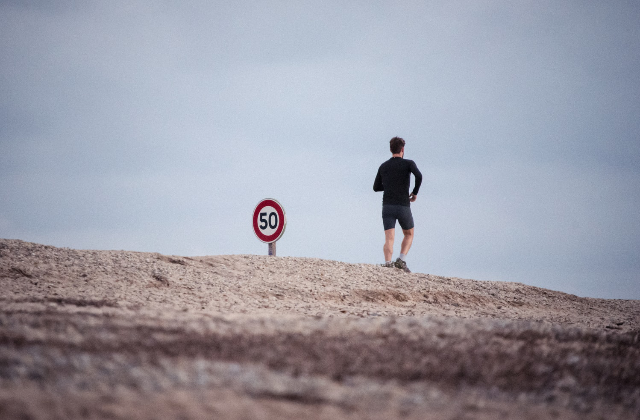

In [46]:
# load the image on 640 * 420 

url = 'https://images.unsplash.com/photo-1456132022829-e771cbd1f7da?ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=1498&q=80'

img = url2img(url)
cv2_imshow(img)


In [47]:
# create the accordingly vmaps , scale between 0 to 1 indicate how much to scale the image
# take approximately 50 seconds for both horizontally and vertically  

t = time.time()

vmap_img_h, vmap_h = create_vmap_h(img, 0.6)
vmap_img_v, vmap_v = create_vmap_v(img, 0.6)

print('Finished create the vmaps after {} seconds'.format(time.time() - t))

Finished create the vmaps after 54.546587228775024 seconds


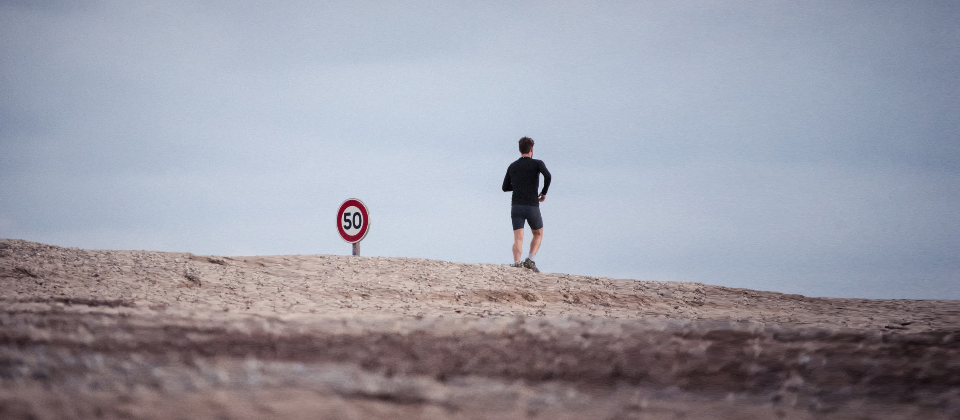

In [48]:
# scale the image
# pass scale , vmap_img, vmap, true for horizontal and false for vertically 

scale_img = scale_img_(img, 1.5, vmap_img_h, vmap_h, True)

cv2_imshow(scale_img)

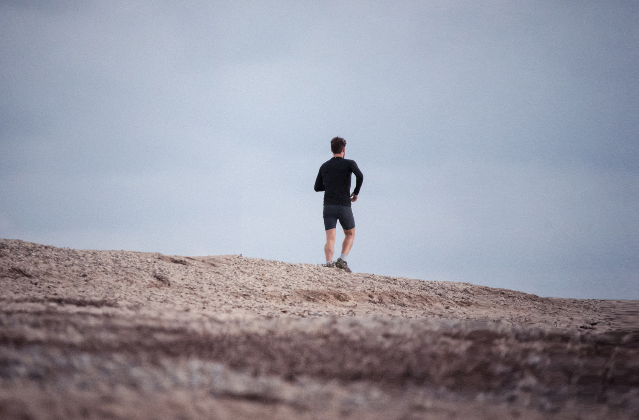

In [49]:
# removing the sign from the image
 
new_img = object_removal(img,239, 299, 196, 253)

cv2_imshow(new_img)